<a href="https://colab.research.google.com/github/malojan/edf_un_climate/blob/master/code/measurement/training_bert.ipynb?authuser=0" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training to classify UNGA speeches on climate change

This notebook contains the code to fine-tune a DEBERTA transformer model to classify [UNGA speeches](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0TJX8Y) on climate change. The script is adapted from Moritz Laurer and Hauke Licht's notebooks on transformer fine-tuning.

In order to run this notebook on a GPU, click on "Runtime" > "Change runtime type" > select "GPU" in the menue bar in to top left. Training a Transformer is much faster on a GPU. Given Google's usage limits for GPUs, it is advisable to first test your non-training code on a CPU (Hardware accelerator "None" instead of GPU) and only use the GPU once you know that everything is working.

#### Setup

In [29]:
# check if on colab
try:
    import google.colab
    COLAB = True

except:
    COLAB=False
print('on colab:', COLAB)

on colab: True


In [30]:
%%capture

# need to install libraries if on Colab
if COLAB:
    !pip install optuna==3.5.0 transformers==4.36.2 sentencepiece==0.1.99 openpyxl==3.0.10 datasets==2.6.0 accelerate==0.23.0


In [31]:
# Load packages

import pandas as pd
import numpy as np
import os

# dataset loading
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# fine-tuning
from transformers import (
    # used to tokenize text
    AutoTokenizer,
    # used to load the pre-trained model
    AutoModelForSequenceClassification,
    # used to finetune the pre-trained model
    Trainer, TrainingArguments, DataCollatorWithPadding, logging,
    pipeline
)

# evaluation
from sklearn.metrics import precision_recall_fscore_support

# set random seed for reproducibility
SEED_GLOBAL = 42
np.random.seed(SEED_GLOBAL)

In [32]:
# set working directory to base of repo

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')  # Might need to adapt to your path
    if not os.getcwd().endswith("edf_un_climate"):
        os.chdir("drive/MyDrive/edf_un_climate")
else:
    if not os.getcwd().endswith("edf_un_climate"):
        os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))
    print(os.getcwd())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import data

In [33]:
#!pip install openpyxl
annotations = pd.read_excel('annotations/annotations.xlsx')

In [34]:
annotations = annotations[['text', 'label', 'label_text']]

In [35]:
# Import labels
labels = pd.read_csv('annotations/2023-12-29-activeTigger-climate.csv', sep=';')

labels.rename(columns={'...1':'id'}, inplace=True) # Rename ..1 column to id

# Keep only the id and the label column. Drop the rest.

labels = labels[['id', 'label', "label_text"]]


text = pd.read_csv('annotations/pool_active.csv')
# Merge the labels and the text dataframes on the id column

df = pd.merge(text, labels, on='id')

# Keep only the tows where label is not NAN

df = df[df['label'].notna()]
df = df[~df['text'].isin(annotations['text'])]
df


,id,text,label,label_text
0,0,The Mauritanian experiment is a good example t...,0.0,other
1,1,"In this regard, we also support the efforts be...",0.0,other
2,2,The reason why the issue is relevant for so ma...,0.0,other
3,3,Let \nus remember the victims of slavery and a...,0.0,other
4,4,And both are democracies and base their econom...,0.0,other
...,...,...,...,...
49951,49951,"I am\nhappy to report that Cyprus, earlier thi...",0.0,other
49958,49958,We are no longer capable of solving abject pov...,1.0,climate
49961,49961,We are also proud of our contribution to the c...,1.0,climate
49974,49974,So we have looked at the contribution we can \...,1.0,climate


In [36]:
# Bind the annotations and df dataframes

df = pd.concat([df, annotations])

In [37]:
df

,id,text,label,label_text
0,0.0,The Mauritanian experiment is a good example t...,0.0,other
1,1.0,"In this regard, we also support the efforts be...",0.0,other
2,2.0,The reason why the issue is relevant for so ma...,0.0,other
3,3.0,Let \nus remember the victims of slavery and a...,0.0,other
4,4.0,And both are democracies and base their econom...,0.0,other
...,...,...,...,...
2495,NaN,"With regard to open membership, Palau believes...",0.0,other
2496,NaN,We too are disappointed that the climate chang...,1.0,climate
2497,NaN,Access to concessional financing represents an...,0.0,other
2498,NaN,Papua New Guinea wishes to express its appreci...,1.0,climate


In [ ]:
# Rename the column label to labels



In [38]:
print(df.value_counts('label_text'))

# Check if duplicates in the text column

df[df.duplicated(subset=['text'])]

# Drop duplicates in the text column

df = df.drop_duplicates(subset=['text'])

df[df.duplicated(subset=['text'])]

# Remove line breaks from the text column

df['text'] = df['text'].str.replace('\n', ' ')



label_text
other      3864
climate    1770
dtype: int64


<ipython-input-38-137fdb4717ed>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.replace('\n', ' ')


In [39]:
# Print 5 text sample exemples of the "climate" label category, add lines break between them

print(*df[df['label_text'] == 'climate'].sample(10, random_state= SEED_GLOBAL)['text'], sep='\n\n')

We demand that the countries of the North  comply with and strengthen the commitments they  undertook in the context of the United Nations  Framework Convention on Climate Change and Kyoto  Protocol regarding measures for adaptation and  mitigation, the development and transfer of  technologies and their financing.

The  post-Kyoto framework should be flexible and diverse,  taking into consideration circumstances in each  country.

A few hours ago, the world’s leading climate scientists, through the Intergovernmental Panel on Climate Change (IPCC), issued a report that adds a new dimension of horror to the world that our children and grandchildren will inherit.

Together, the Sustainable Development Goals (SDGs) and the Paris Climate Change Agreement provide a framework and vision for a more sustainable planet in the future and prosperity for all.

We will not waver in our support of the Chilean presidency of the twenty-fifth Conference of the Parties to the United Nations Framework Co

In [40]:
id2label = {0: 'other', 1: 'climate'}
# alternatively: `id2label = dict(enumerate(df.position.unique()))?
label2id = {v: k for k, v in id2label.items()}

# encode label indicator
df['label'] = df['label_text'].map(label2id)
df[['label', 'label_text']].value_counts()

cols = ['text', 'label', 'label_text']
df = df[cols].reset_index(drop=True)

<ipython-input-40-48e2e3857eee>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label_text'].map(label2id)


In [41]:
# Split the dataframe into train, validation and test sets

# use 15% of the data for dev and test, respectively
n = len(df)

test_size = 0.15
n_test = int(n*test_size)

dev_size = 0.15
n_dev = int(n*dev_size)

tmp, test_idxs = train_test_split(range(n), test_size=n_test, random_state=SEED_GLOBAL, stratify=df.label)
train_idxs, dev_idxs = train_test_split(tmp, test_size=n_dev, random_state=SEED_GLOBAL, stratify=df.label.iloc[tmp])
del tmp

print("Length of training and test sets after sampling: ", len(train_idxs), " (train) ", len(dev_idxs), " (dev) ", len(test_idxs), " (test).")
print(len(set(train_idxs).intersection(set(dev_idxs)))) # should be 0
print(len(set(train_idxs).intersection(set(test_idxs)))) # should be 0
print(len(set(dev_idxs).intersection(set(test_idxs)))) # should be 0

Length of training and test sets after sampling:  3935  (train)  843  (dev)  843  (test).
0
0
0


In [42]:
df.iloc[train_idxs]

# Train random forest classifier on the training set with Scikit-learn

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Create a vectorizer object to generate term document counts

vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)

# Fit and transform train set, transform test set

X_train = vectorizer.fit_transform(df.iloc[train_idxs]['text'])
X_dev = vectorizer.transform(df.iloc[dev_idxs]['text'])
X_test = vectorizer.transform(df.iloc[test_idxs]['text'])

# Transform labels to integers

y_train = df.iloc[train_idxs]['label']
y_dev = df.iloc[dev_idxs]['label']
y_test = df.iloc[test_idxs]['label']

# Train random forest classifier on the training set with Scikit-learn

clf = RandomForestClassifier(n_estimators=100, random_state=SEED_GLOBAL)
clf.fit(X_train, y_train)

# Predict on the dev set

y_pred = clf.predict(X_dev)

# Evaluate the model on the dev set

precision, recall, f1, _ = precision_recall_fscore_support(y_dev, y_pred, average='binary')

print(f"Performance on the validation set : Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# Predict on the test set

y_pred = clf.predict(X_test)

# Evaluate the model on the test set

# Evaluate the model on the test set
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
accuracy = accuracy_score(y_test, y_pred)

print(f"Performance on the test set : Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, Accuracy: {accuracy:.3f}")


# Compute the accuracy




Performance on the validation set : Precision: 0.964, Recall: 0.917, F1: 0.940
Performance on the test set : Precision: 0.961, Recall: 0.925, F1: 0.942, Accuracy: 0.964


In [43]:
# Print the text that are false positives

df.iloc[test_idxs][y_pred > y_test].text.to_list()

['In short, we need an ambitious, high- performance, legally binding agreement with global participation.',
 'Like others, therefore, my delegation cannot help but state its concern at the ever-worsening international climate.',
 'While we recognize that fossil fuel  will, in the medium term, remain a necessity, the  current energy crisis strengthens Micronesia’s resolve  to call for the acceleration of the development of  technologies for renewable and affordable sources of  energy.',
 'Weighed down by its debt, by the fall in raw material prices, by the deterioration in its terms of trade and by natural disasters, fluctuations in climate, desertification and drought, Africa is staggering from one calamity to the next.',
 'At a high cost and at great risk, we in Honduras decided to face this monstrous multiheaded challenge, and like very few countries in the region we have made progress, increasingly entrenching a climate of greater security and peace each day.',
 'Agricultural produc

- The model has more difficult to disantangle the polysemy of the word "climate"

In [44]:
# Print the text that are false negatives

df.iloc[test_idxs][y_pred < y_test].text.to_list()

['Just last week, a new study found that half of all coral reefs could be lost with a temperature rise above 1.2 degrees Celsius.',
 'That is why I took on the role of President of COP- 23 and why I have eagerly embraced the opportunity to be the first Pacific Islander to do so.',
 'Europe will continue to use its clout,  its influence and its resources to uphold peace and  justice, to encourage development and cooperation  and to promote climate protection and disarmament  throughout the world.',
 'We believe that international conferences such as the Doha, Monterrey and Johannesburg summits and their plans of action are blueprints to resolve many of the pressing global challenges and needs, including poverty eradication; sustainable development; environmental degradation and climatic changes; and social ills, including HIV/ AIDS and other preventable diseases.',
 'The heightened occurrence of catastrophic climatic-related disasters all over the world attest to why we must act with ab

In [45]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df.iloc[train_idxs], preserve_index=False),
    "dev": Dataset.from_pandas(df.iloc[dev_idxs], preserve_index=False),
    "test": Dataset.from_pandas(df.iloc[test_idxs], preserve_index=False),
})

# check label distribution

print('% "pos" in train:', np.mean([ex['label'] for ex in dataset["train"]]))
print('% "pos" in dev:', np.mean([ex['label'] for ex in dataset["dev"]]))
print('% "pos" in test:', np.mean([ex['label'] for ex in dataset["test"]]))


% "pos" in train: 0.31461245235069885
% "pos" in dev: 0.3143534994068802
% "pos" in test: 0.3143534994068802


## Load a Transformer

In [46]:
import torch
# check if GPU or MPS is available, else use CPU
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
device

device(type='cuda')

In [47]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import torch

## load a model and its tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, model_max_length=512)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

dataset = dataset.map(preprocess_function, batched=True)
dataset = dataset.remove_columns(['label_text'])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [48]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, # <== the name of the pre-trained model (downloaded from huggingface hub)
    num_labels=len(id2label), # number of label classes (adapt this if you have, e.g., 4 label classes)
    id2label=id2label,
    label2id=label2id
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
# IMPORTANT: put the model to the respective device (e.g., GPU)
if str(device) != 'cpu':
  model.to(device);
print(model.device)

cuda:0


#### Create metrics

In [50]:
### Function to calculate metrics
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, accuracy_score, classification_report
import warnings

def compute_metrics_standard(eval_pred):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        labels = eval_pred.label_ids
        pred_logits = eval_pred.predictions
        preds_max = np.argmax(pred_logits, axis=1)  # argmax on each row (axis=1) in the tensor

        # metrics
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, preds_max, average='macro')  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
        precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(labels, preds_max, average='micro')  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
        acc_balanced = balanced_accuracy_score(labels, preds_max)
        acc_not_balanced = accuracy_score(labels, preds_max)

        metrics = {
            'accuracy': acc_not_balanced,
            'f1_macro': f1_macro,
            'accuracy_balanced': acc_balanced,
            'f1_micro': f1_micro,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'precision_micro': precision_micro,
            'recall_micro': recall_micro,
        }

        return metrics


#### Setting training arguments

The following cells set several important hyperparameters. We chose parameters that work well in general to avoid the need for hyperparameter search. Further below, we also provide code for hyperparameter search, if researchers want to try to increase performance by a few percentage points.

In [51]:
# create a temporary directory to store the model predictions
# create a temporary folder to save training checkpoints and logs
# With google colab, this will create a temporary folder, which will be deleted once you disconnect.
# You can connect to your personal google drive to save models and logs properly.

import tempfile
model_path = tempfile.mkdtemp()

In [52]:
# FP16 is a hyperparameter which can increase training speed and reduce memory consumption, but only on GPU and if batch-size > 8, see here: https://huggingface.co/transformers/performance.html?#fp16
# FP16 does not work on CPU or for multilingual mDeBERTa models
fp16_bool = True if torch.cuda.is_available() else False
if "mdeberta" in model_name.lower(): fp16_bool = False  # multilingual mDeBERTa does not support FP16 yet: https://github.com/microsoft/DeBERTa/issues/77
# in case of hyperparameter search end the end: FP16 has to be set to False. The integrated hyperparameter search with the Hugging Face Trainer can lead to errors otherwise.
fp16_bool = False

In [56]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [57]:
LEARNING_RATE = 2e-5  # can try: 6e-5
EPOCHS = 5  # can try: 10

# Hugging Face tipps to increase training speed and decrease out-of-memory (OOM) issues: https://huggingface.co/transformers/performance.html?
# Overview of all training arguments: https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments
train_args = TrainingArguments(
    output_dir=f'unga-climate-classifier',
    logging_dir=f'./logs/{model_path}',
    num_train_epochs=EPOCHS,  # this can be increased, but higher values increase training time. Good values for NLI are between 3 and 20.
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=16,  # if you get an out-of-memory error, reduce this value to 8 or 4 and restart the runtime. Higher values increase training speed, but also increase memory requirements. Ideal values here are always a multiple of 8.
    per_device_eval_batch_size=80,  # if you get an out-of-memory error, reduce this value, e.g. to 40 and restart the runtime
    gradient_accumulation_steps=2, # Can be used in case of memory problems to reduce effective batch size. accumulates gradients over X steps, only then backward/update. decreases memory usage, but also slightly speed. (!adapt/halve batch size accordingly)
    warmup_ratio=0.06,  # a good normal default value is 0.06 for normal BERT-base models, but since we want to reuse prior NLI knowledge and avoid catastrophic forgetting, we set the value higher
    weight_decay=0.1,
    seed=SEED_GLOBAL,
    data_seed=SEED_GLOBAL,
    full_determinism=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # fp16=fp16_bool,  # Can speed up training and reduce memory consumption, but only makes sense at batch-size > 8. loads two copies of model weights, which creates overhead. https://huggingface.co/transformers/performance.html?#fp16
    fp16_full_eval=fp16_bool,
    evaluation_strategy="epoch", # options: "no"/"steps"/"epoch"
    #eval_steps=10_000,  # evaluate after n steps if evaluation_strategy!='steps'. defaults to logging_steps
    save_strategy = "epoch",  # options: "no"/"steps"/"epoch"
    #save_steps=10_000,              # Number of updates steps before two checkpoint saves.
    #save_total_limit=10,             # If a value is passed, will limit the total amount of checkpoints. Deletes the older checkpoints in output_dir
    logging_strategy="steps",
    report_to="all",  # "all"  # logging
    push_to_hub=True,
    #push_to_hub_model_id= "unga-climate",
)


## Fine-tuning and evaluation

Let's start fine-tuning the model!

If you get an 'out-of-memory' error, reduce the 'per_device_train_batch_size' to 8 or 4 in the TrainingArguments above and restart the runtime. If you don't restart your runtime (menu to the to left 'Runtime' > 'Restart runtime') and rerun the entire script, the 'out-of-memory' error will probably not go away.

In [58]:
# training
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=train_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["dev"],
    compute_metrics=compute_metrics_standard
)

In [59]:
trainer.train()

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Accuracy Balanced,F1 Micro,Precision Macro,Recall Macro,Precision Micro,Recall Micro
1,No log,0.177835,0.960854,0.954264,0.951018,0.960854,0.957712,0.951018,0.960854,0.960854
2,No log,0.161440,0.967972,0.962579,0.959274,0.967972,0.966090,0.959274,0.967972,0.967972
3,No log,0.159824,0.967972,0.962579,0.959274,0.967972,0.966090,0.959274,0.967972,0.967972
4,No log,0.119099,0.970344,0.965278,0.961004,0.970344,0.969895,0.961004,0.970344,0.970344
5,0.135700,0.140004,0.972716,0.968056,0.963756,0.972716,0.972700,0.963756,0.972716,0.972716


TrainOutput(global_step=615, training_loss=0.11612840125231239, metrics={'train_runtime': 665.4098, 'train_samples_per_second': 29.568, 'train_steps_per_second': 0.924, 'total_flos': 689639804876088.0, 'train_loss': 0.11612840125231239, 'epoch': 5.0})

In [ ]:
import shutil

shutil.rmtree(model_path)

In [60]:
# evaluate the final model on the held-out tetst set
trainer.evaluate(dataset["test"])
#print(results)

{'eval_loss': 0.09357842803001404,
 'eval_accuracy': 0.9798339264531435,
 'eval_f1_macro': 0.976537059200089,
 'eval_accuracy_balanced': 0.9750767121498989,
 'eval_f1_micro': 0.9798339264531435,
 'eval_precision_macro': 0.9780353693946999,
 'eval_recall_macro': 0.9750767121498989,
 'eval_precision_micro': 0.9798339264531435,
 'eval_recall_micro': 0.9798339264531435,
 'eval_runtime': 5.9264,
 'eval_samples_per_second': 142.245,
 'eval_steps_per_second': 1.856,
 'epoch': 5.0}

In [61]:
trainer.push_to_hub()


CommitInfo(commit_url='https://huggingface.co/mljn/unga-climate-classifier/commit/f4fd2ff72e0a88a422f783886ac89a1b80de4c29', commit_message='End of training', commit_description='', oid='f4fd2ff72e0a88a422f783886ac89a1b80de4c29', pr_url=None, pr_revision=None, pr_num=None)

#### Qualitative evaluation of the model predictions

In [64]:
rng = np.random.default_rng(SEED_GLOBAL)
idxs = rng.choice(len(dataset["test"]), 100, replace=False)
preds = trainer.predict(dataset["test"].select(idxs))
pd.DataFrame(
    {
        'text': dataset["test"][idxs]['text'],
        'label': [id2label[l] for l in dataset["test"][idxs]['label']],
        'prediction': [id2label[pp] for pp in preds.predictions.argmax(axis=1)],
    }
  )

,text,label,prediction
0,The fight against climate change is closely c...,climate,climate
1,The same story recurs in the case of cotton gr...,other,other
2,"Of course, we look forward to next year’s clim...",climate,climate
3,The proclaimed breakdown of the Paris Climate ...,climate,climate
4,"With this trust, last week Mexico deposited it...",climate,climate
...,...,...,...
95,"Just last week, a new study found that half of...",climate,climate
96,The conservation and sustainable use of the Am...,climate,climate
97,He welcome the spirit of constructive cooperat...,other,other
98,The heightened occurrence of catastrophic clim...,climate,other


Text: The rising sea levels due to melting polar ice caps are a clear indication of climate change. 
Label: climate 
Score: 0.9988040924072266

Text: The apple on the table is ripe. 
Label: other 
Score: 0.9977114200592041

Text: Banks of clouds obscured the sun, hinting at a possible change in weather. 
Label: other 
Score: 0.9920691251754761

Text: She spent the afternoon in the bank, organizing her finances. 
Label: other 
Score: 0.9983586668968201

Text: Global efforts to reduce carbon emissions are crucial in combating the greenhouse effect. 
Label: climate 
Score: 0.9987369179725647

Text: The novel's plot took an unexpected turn in the last chapter. 
Label: other 
Score: 0.9978604912757874

Text: Renewable energy sources like solar and wind power are key to sustainable development. 
Label: other 
Score: 0.9947591423988342

Text: He wore a bright red tie for his job interview. 
Label: other 
Score: 0.9976834058761597

Text: The Paris agreement is a great achievement 
Label: clima

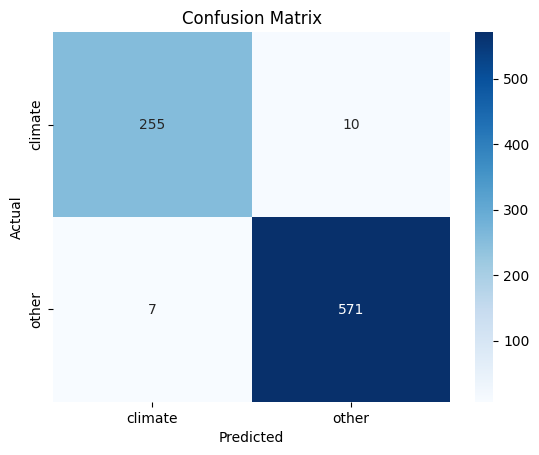

In [65]:

device = "cuda:0" if torch.cuda.is_available() else "cpu"  # use GPU (cuda) if available, otherwise use CPU

# documentation: https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.ZeroShotClassificationPipeline
climate_classifier = pipeline(
    "text-classification",
    model=model,  # if you have trained a model above, load_best_model_at_end in the training arguments has automatically replaced model with the fine-tuned model
    tokenizer=tokenizer,
    framework="pt",
    device=device,
)

## Create a list of sentences related to climate change and some of them are not or ambiguous

sentences = [
    "The rising sea levels due to melting polar ice caps are a clear indication of climate change.",
    "The apple on the table is ripe.",
    "Banks of clouds obscured the sun, hinting at a possible change in weather.",
    "She spent the afternoon in the bank, organizing her finances.",
    "Global efforts to reduce carbon emissions are crucial in combating the greenhouse effect.",
    "The novel's plot took an unexpected turn in the last chapter.",
    "Renewable energy sources like solar and wind power are key to sustainable development.",
    "He wore a bright red tie for his job interview.",
    "The Paris agreement is a great achievement"
]

## APply the classifier to the list of sentences and print the result as text : climate or not climate

results = climate_classifier(sentences)


# Visualizing the results
for sentence, result in zip(sentences, results):
    print(f"Text: {sentence} \nLabel: {result['label']} \nScore: {result['score']}\n")

# Obtein test set of dataset in a df format


# create a dummy data frame for illustration
test_df = dataset["test"].to_pandas()
text_lst = test_df["text"].tolist()


# use the pipeline with your chosen model for inference (prediction)
test_output = climate_classifier(
    text_lst,  # input any list of texts here
    batch_size=32  # reduce this number to 8 or 16 if you get an out-of-memory error
)
print(test_output)


df_output = pd.DataFrame(test_output)
# add inference data to your original dataframe
test_df["label_text_pred"] = df_output["label"].tolist()
test_df["label_text_pred_probability"] = df_output["score"].round(2).tolist()

# Create a column label_text that has climate when label is 1 and other when label is 0

test_df['label_text'] = test_df['label'].map(id2label)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have two lists or pandas Series: label_text and label_text_pred
# Compute the confusion matrix
confusion = confusion_matrix(test_df['label_text'], test_df['label_text_pred'])

# Define class labels (assuming "climate" and "other")
class_labels = ["climate", "other"]

# Create a heatmap for the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [66]:
import pandas as pd

# Assuming 'test_df' is a pandas DataFrame with the columns 'label_text', 'label_text_pred', and 'text'

def get_false_negatives(df):
    """
    Retrieves all instances of false negatives from the dataframe.

    :param df: DataFrame containing the data.
    """
    return df[(df['label_text'] == 'climate') & (df['label_text_pred'] == 'other')].text.to_list()

def get_false_positives(df):
    """
    Retrieves all instances of false positives from the dataframe.

    :param df: DataFrame containing the data.
    """
    return df[(df['label_text'] == 'other') & (df['label_text_pred'] == 'climate')].text.to_list()

# Function to display texts with numbering and without internal line breaks
def display_texts_with_numbering(texts, label):
    print(f"{label}:")
    for i, text in enumerate(texts, 1):
        cleaned_text = text.replace('\n', ' ').replace('\r', '')  # Removing internal line breaks
        print(f"Text {i}: {cleaned_text}")
    print()  # Line break after the group

# Display false negatives
false_negatives = get_false_negatives(test_df)
display_texts_with_numbering(false_negatives, "False Negatives")

# Display false positives
false_positives = get_false_positives(test_df)
display_texts_with_numbering(false_positives, "False Positives")


False Negatives:
Text 1: First, I would like to ask all members to do everything possible to implement the historic Agreement that was signed in Paris on 12 December 2015.
Text 2: The heightened occurrence of catastrophic climatic-related disasters all over the world attest to why we must act with absolute urgency even in the wake of the pandemic.
Text 3: My country today appeals to developed countries to meet the commitments they undertook at the United Nations Conference on Environment and Development, held at Rio de Janeiro, especially with respect to the provision of technical assistance to developing countries.
Text 4: We are about to submit our revised nationally determined contributions to contribute to this critical global effort.
Text 5: According  to reliable forecasts, Kyrgyzstan’s ice cover could be  reduced by 40 per cent by 2025, leading to a one third  drop in the water available in the region.
Text 6: I echo the sentiments on NCDs expressed  by Pacific leaders regarding

Problems :

- The classifier is not good at detecting "COP". What would be a solution ? To have stratified random sampling of COPS ?

#### Compare with dictionary-based classification

In [68]:
# Create a list of keywords undoubtly related to climate change

keywords = ['climate change', 'global warming', "greenhouse gas", "carbon dioxide", "climate crisis", "climate action"]

# Create a column and apply climate when the keywords is detect and other if not

test_df['climate_keywords'] = test_df['text'].apply(lambda x: 'climate' if any(word in x for word in keywords) else 'other')

## Create scatter plot of the label_text and the climate_keywords columns

# Create a column and apply climate when the keywords is detect and other if not
# Compute prediction accuracy, recall and precision and f1 score for the keywords

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print("Accuracy:", accuracy_score(test_df['label_text'], test_df['climate_keywords']))
print("Recall:", recall_score(test_df['label_text'], test_df['climate_keywords'], pos_label='climate'))
print("Precision:", precision_score(test_df['label_text'], test_df['climate_keywords'], pos_label='climate'))
print("F1 score:", f1_score(test_df['label_text'], test_df['climate_keywords'], pos_label='climate'))

Accuracy: 0.8623962040332147
Recall: 0.5622641509433962
Precision: 1.0
F1 score: 0.7198067632850241


- Dictionnaries are good at precision, but not at recall
- The transformer model is good at both

#### Save and load your fine-tuned model

##### Saving your model to Google Drive

In [ ]:
model_path = os.path.join('..', 'models', 'unga_climate_classifier')
os.makedirs(model_path, exist_ok=True)
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)
os.listdir(model_path)


In [ ]:
## first you need to connect to your google drive with your google account
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=False)
#drive.flush_and_unmount()

# insert the path where you want to save the model
os.chdir("/content/drive/My Drive/")
print(os.getcwd())

### save best model to google drive
directory_save_model = f"{model_path}/"
model_name_custom = "unga-climate"
mode_custom_path = directory_save_model + model_name_custom

trainer.save_model(output_dir=mode_custom_path)

### Upload your model to the Hugging Face Hub

In [ ]:
### Push to Hugging Face hub
# install necessary dependencies
# you need to create an account on https://huggingface.co/ for this
# load your models and tokenizer saved before from disk
!sudo apt-get install git-lfs
!huggingface-cli login
model = AutoModelForSequenceClassification.from_pretrained(mode_custom_path)
tokenizer = AutoTokenizer.from_pretrained(mode_custom_path, use_fast=True, model_max_length=512)  # we load the tokenizer from the original BERT-NLI model

model.push_to_hub(repo_id = "unga-climate-classifier", use_temp_dir=True)
tokenizer.push_to_hub(repo_id = "unga-climate-classifier")

#### Bonus: Hyperparameter Search

To increase performance, it is possible to do hp-search to find the best hyperparameters. But : computationnaly intensive.

Note that for small datasets, running the hp-search only on one train-validation split is not ideal. For datasets with less than around 2000 training data points, we recommend running the hp-search on two different random train-validation split. We implemented this for our paper, but not in this notebook as this would make the code harder to understand.

Documentation with more information on hp-search with Hugging Face Transformers is available [here](https://huggingface.co/docs/transformers/main/hpo_train).

In [ ]:
## train-validation split - test set should not be visible during hp-search
# https://huggingface.co/docs/datasets/v2.5.1/en/package_reference/main_classes#datasets.Dataset.train_test_split

# the ideal size of the validation set depends on the size of your training data. Each label should have at the very least a few dozen examples in the validation set (ideally several hundred)
validation_set_size = 0.4  # for a training data size of 1000 with 3 classes we use 40% of the training data for validating hyperparameters

# reformatting of label column to enable dataset stratification
from datasets import ClassLabel
new_features = dataset["train"].features.copy()
label_names = list(model.config.label2id.keys())

new_features['label'] = ClassLabel(names=label_names)
dataset = dataset.cast(new_features)

# train-validation split for hp-search
dataset_hp = dataset["train"].train_test_split(test_size=validation_set_size, seed=SEED_GLOBAL, shuffle=True, stratify_by_column="label")
print(dataset_hp)

In [ ]:
# helper function to clean memory and reduce risk of out-of-memory error
import gc
def clean_memory():
  #del(model)
  if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
  gc.collect()

clean_memory()

In [ ]:
## Reinitialize trainer for hp-search
# https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10

def model_init():
    clean_memory()

    # link the numeric labels to the label texts
    label_text = np.sort(df_test.label_text.unique()).tolist()
    label2id = dict(zip(np.sort(label_text), np.sort(pd.factorize(label_text, sort=True)[0]).tolist()))
    id2label = dict(zip(np.sort(pd.factorize(label_text, sort=True)[0]).tolist(), np.sort(label_text)))
    config = AutoConfig.from_pretrained(model_name, label2id=label2id, id2label=id2label, num_labels=len(label2id));

    return AutoModelForSequenceClassification.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True).to(device)

trainer = Trainer(
    model_init=model_init,
    tokenizer=tokenizer,
    args=train_args,
    train_dataset=dataset_hp["train"],
    eval_dataset=dataset_hp["test"],
    compute_metrics=compute_metrics_standard
);


**Define the hyperparameters you want to optimise**

For a detailed discussion of different hyperparameters, see the appendix of our paper.

In [ ]:
# we use Optuna for hp-search: https://optuna.readthedocs.io/en/stable/
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_categorical("learning_rate", [9e-6, 2e-5, 4e-5]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 4, 24, log=False, step=4),   # increasing the maximum number of epochs here could increase performance but will take (much) longer to train
        #"warmup_ratio": trial.suggest_float("warmup_ratio", 0.1, 0.6, log=True),
        "per_device_train_batch_size": 16,  # lower this value in case of out-of-memory errors and restart the runtime
        #"per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "evaluation_strategy": "no",
        "save_strategy": "no",
    }


**Run HP search!**

Choose the number of hyperparameter configurations you want to test. In our experiments we found that after 10 to 15 trials with around 4 hyperparameters, performance is unlikely to increase meaningfully. 15 trials seems to be a safe value, but can take a while to run.

In [ ]:
import optuna

# number of differen hp configurations to test
numer_of_trials = 10  # increasing this value can lead to better hyperparameters, but will take longer
# chose the sampler for sampling hp configurations
optuna_sampler = optuna.samplers.TPESampler(
    seed=SEED_GLOBAL, consider_prior=True, prior_weight=1.0, consider_magic_clip=True,
    consider_endpoints=False, n_startup_trials=numer_of_trials/2, n_ei_candidates=24,
    multivariate=False, group=False, warn_independent_sampling=True, constant_liar=False
)  # https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler

# Hugging Face Documentation: https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.hyperparameter_search
best_run = trainer.hyperparameter_search(
    n_trials=numer_of_trials,
    direction="maximize",
    hp_space=my_hp_space,
    backend='optuna',
    **{"sampler": optuna_sampler}
)

In [ ]:
# show best hyperparameters based on hp-search
print(best_run)

**Training Time with optimised hyperparameters!**

Here we can use the original train and test set again.

In [ ]:
# update the training arguments with the best hyperparameters
for k,v in best_run.hyperparameters.items():
    setattr(train_args, k, v)
print("\n", train_args)

# hp-search with hf causes errors with FP16 for some reason
#setattr(train_args, "fp16", False)
#setattr(train_args, "fp16_full_eval", False)

In [ ]:
# reinitialize the model to avoid re-using a trained model from a step further above
#model_name = "XXX"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, model_max_length=512)

# link the numeric labels to the label texts
label_text = np.sort(df_test.label_text.unique()).tolist()
label2id = dict(zip(np.sort(label_text), np.sort(pd.factorize(label_text, sort=True)[0]).tolist()))
id2label = dict(zip(np.sort(pd.factorize(label_text, sort=True)[0]).tolist(), np.sort(label_text)))
config = AutoConfig.from_pretrained(model_name, label2id=label2id, id2label=id2label, num_labels=len(label2id));

# load model with config
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True);


In [ ]:
# Training
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=train_args,
    train_dataset=dataset["train"],  #.shard(index=1, num_shards=100),  # https://huggingface.co/docs/datasets/processing.html#sharding-the-dataset-shard
    eval_dataset=dataset["test"],  #.shard(index=1, num_shards=100),
    compute_metrics=lambda eval_pred: compute_metrics_nli_binary(eval_pred, label_text_alphabetical=label_text_alphabetical)
)

trainer.train()


In [ ]:
## Evaluate the fine-tuned model on the held-out test set
results = trainer.evaluate()


In [ ]:
print(results)

Note that hyperparameter searches do not necessarily lead to better results, as they need to be searched on a smaller validation set of the train set, which might impact generalisation. Especially for smaller training sets, hyperparameter searches might lead to similar values as good default values. The default values discussed in the paper often provide good results.